In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy import stats
import inspect
from statsmodels.distributions.empirical_distribution import ECDF
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

In [1]:
import warnings

# Configuración para ignorar warnings
warnings.filterwarnings('ignore')

In [60]:
# Datos
datos = sns.load_dataset('diamonds')
datos = datos.loc[datos.cut == 'Fair', 'price']

In [61]:
print(datos)

8         337
91       2757
97       2759
123      2762
124      2762
         ... 
53757    2724
53800    2732
53863    2743
53879    2745
53882    2747
Name: price, Length: 1610, dtype: int64


In [63]:

import inspect
class AjusteDistribuciones:
    """
    Clase para ajustar y comparar distribuciones estadísticas usando scipy.stats.

    Attributes:
        distribuciones (list): Lista de distribuciones disponibles en scipy.stats.
        distribucion_ (list): Nombre de la distribución ajustada.
        log_likelihood_ (list): Valor de log-likelihood para cada distribución ajustada.
        aic_ (list): Valor del criterio de información de Akaike (AIC) para cada distribución ajustada.
        bic_ (list): Valor del criterio de información bayesiano (BIC) para cada distribución ajustada.
        n_parametros_ (list): Número de parámetros de cada distribución ajustada.
        parametros_ (list): Parámetros estimados para cada distribución ajustada.

    Methods:
        seleccionar_distribuciones(familia='realall', verbose=True):
            Selecciona un subconjunto de distribuciones basado en la familia especificada.
        comparar_distribuciones(x, familia='realall', ordenar='aic', verbose=True):
            Ajusta y compara un subconjunto de distribuciones a los datos dados.
    """

    def __init__(self):
        """
        Inicializa un objeto AjusteDistribuciones.
        """
        self.distribuciones = []
        self.distribucion_ = []
        self.log_likelihood_ = []
        self.aic_ = []
        self.bic_ = []
        self.n_parametros_ = []
        self.parametros_ = []

    @property
    def distribucion(self):
        """
        Obtiene el nombre de la distribución ajustada.

        Returns:
            list: Nombre de la distribución ajustada.
        """
        return self.distribucion_

    @distribucion.setter
    def distribucion(self, value):
        """
        Establece el nombre de la distribución ajustada.

        Args:
            value (list): Nuevo nombre de la distribución ajustada.
        """
        self.distribucion_ = value

    @property
    def log_likelihood(self):
        """
        Obtiene el valor de log-likelihood para cada distribución ajustada.

        Returns:
            list: Valor de log-likelihood para cada distribución ajustada.
        """
        return self.log_likelihood_

    @log_likelihood.setter
    def log_likelihood(self, value):
        """
        Establece el valor de log-likelihood para cada distribución ajustada.

        Args:
            value (list): Nuevo valor de log-likelihood para cada distribución ajustada.
        """
        self.log_likelihood_ = value

    @property
    def aic(self):
        """
        Obtiene el valor del criterio de información de Akaike (AIC) para cada distribución ajustada.

        Returns:
            list: Valor de AIC para cada distribución ajustada.
        """
        return self.aic_

    @aic.setter
    def aic(self, value):
        """
        Establece el valor del criterio de información de Akaike (AIC) para cada distribución ajustada.

        Args:
            value (list): Nuevo valor de AIC para cada distribución ajustada.
        """
        self.aic_ = value

    @property
    def bic(self):
        """
        Obtiene el valor del criterio de información bayesiano (BIC) para cada distribución ajustada.

        Returns:
            list: Valor de BIC para cada distribución ajustada.
        """
        return self.bic_

    @bic.setter
    def bic(self, value):
        """
        Establece el valor del criterio de información bayesiano (BIC) para cada distribución ajustada.

        Args:
            value (list): Nuevo valor de BIC para cada distribución ajustada.
        """
        self.bic_ = value

    @property
    def n_parametros(self):
        """
        Obtiene el número de parámetros de cada distribución ajustada.

        Returns:
            list: Número de parámetros de cada distribución ajustada.
        """
        return self.n_parametros_

    @n_parametros.setter
    def n_parametros(self, value):
        """
        Establece el número de parámetros de cada distribución ajustada.

        Args:
            value (list): Nuevo número de parámetros de cada distribución ajustada.
        """
        self.n_parametros_ = value

    @property
    def parametros(self):
        """
        Obtiene los parámetros estimados para cada distribución ajustada.

        Returns:
            list: Parámetros estimados para cada distribución ajustada.
        """
        return self.parametros_

    @parametros.setter
    def parametros(self, value):
        """
        Establece los parámetros estimados para cada distribución ajustada.

        Args:
            value (list): Nuevos parámetros estimados para cada distribución ajustada.
        """
        self.parametros_ = value

    def seleccionar_distribuciones(self, familia='realall', verbose=True):
        '''
        Esta función selecciona un subconjunto de las distribuciones disponibles
        en scipy.stats basado en la familia especificada.

        Parameters
        ----------
        familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
            realall: distribuciones de la familia `realline` + `realplus`
            realline: distribuciones continuas en el dominio (-inf, +inf)
            realplus: distribuciones continuas en el dominio [0, +inf)
            real0to1: distribuciones continuas en el dominio [0,1]
            discreta: distribuciones discretas

        verbose : bool
            Si se muestra información de las distribuciones seleccionadas
            (por defecto `True`).

        Returns
        -------
        distribuciones: list
            Lista con las distribuciones seleccionadas (objetos).

        Raises
        ------
        Exception
            Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
            o 'discreta'.
        '''

        distribuciones = [getattr(stats, d) for d in dir(stats) \
                          if isinstance(getattr(stats, d), (stats.rv_continuous, stats.rv_discrete))]

        exclusiones = ['levy_stable', 'vonmises']
        distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]

        dominios = {
            'realall': [-np.inf, np.inf],
            'realline': [-np.inf, np.inf],
            'realplus': [0, np.inf],
            'real0to1': [0, 1],
            'discreta': [None, None],
        }

        distribucion = []
        tipo = []
        dominio_inf = []
        dominio_sup = []

        for dist in distribuciones:
            distribucion.append(dist.name)
            tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
            dominio_inf.append(dist.a)
            dominio_sup.append(dist.b)

        info_distribuciones = pd.DataFrame({
            'distribucion': distribucion,
            'tipo': tipo,
            'dominio_inf': dominio_inf,
            'dominio_sup': dominio_sup
        })

        info_distribuciones = info_distribuciones \
            .sort_values(by=['dominio_inf', 'dominio_sup']) \
            .reset_index(drop=True)

        if familia == 'discreta':
            distribuciones_seleccionadas = [dist.name for dist in distribuciones if isinstance(dist, stats.rv_discrete)]
        else:
            distribuciones_seleccionadas = [
                'norm', 'expon', 'uniform', 'lognorm', 'weibull_min', 'gamma', 'beta', 'chi2', 't', 'gaussian_kde',
                'bernoulli', 'binom', 'poisson', 'expon'
            ]

        info_distribuciones = info_distribuciones[
            info_distribuciones['distribucion'].isin(distribuciones_seleccionadas)
        ].reset_index(drop=True)

        seleccion = [dist for dist in distribuciones \
                     if dist.name in info_distribuciones['distribucion'].values]

        if verbose:
            print("---------------------------------------------------")
            print("       Distribuciones seleccionadas                ")
            print("---------------------------------------------------")
            with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                print(info_distribuciones)

        return seleccion

    def comparar_distribuciones(self, x, familia='realall', ordenar='aic', verbose=True):
        """
        Ajusta y compara un subconjunto de distribuciones a los datos dados.

        Parameters
        ----------
        x : array_like
            Datos con los que ajustar las distribuciones.

        familia : str, opcional
            Tipo de distribuciones a considerar:
            - 'realall': Todas las distribuciones continuas.
            - 'realline': Distribuciones continuas en el dominio (-inf, +inf).
            - 'realplus': Distribuciones continuas en el dominio [0, +inf).
            - 'real0to1': Distribuciones continuas en el dominio [0,1].
            - 'discreta': Distribuciones discretas.
            (default is 'realall')

        ordenar : {'aic', 'bic'}, opcional
            Criterio de ordenación de mejor a peor ajuste.
            (default is 'aic')

        verbose : bool, opcional
            Si se muestra información detallada de las distribuciones seleccionadas.
            (default is True)

        Returns
        -------
        pandas.DataFrame
            DataFrame con los resultados de ajuste de distribuciones, ordenado por el criterio especificado.

        Raises
        ------
        ValueError
            Si `familia` no es uno de los valores válidos ('realall', 'realline', 'realplus', 'real0to1', 'discreta').

        Notes
        -----
        Este método maneja excepciones al ajustar distribuciones y muestra detalles de los errores si ocurren.
        """
        self.distribucion_ = []
        self.log_likelihood_= []
        self.aic_ = []
        self.bic_ = []
        self.n_parametros_ = []
        self.parametros_ = []

        distribuciones = self.seleccionar_distribuciones(familia=familia, verbose=verbose)

        for i, distribucion in enumerate(distribuciones):
            print(f"{i+1}/{len(distribuciones)} Ajustando distribución: {distribucion}")

            try:
                parametros = distribucion.fit(data=x)
                nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                     if not p=='x'] + ["loc","scale"]
                parametros_dict = dict(zip(nombre_parametros, parametros))
                log_likelihood = distribucion.logpdf(x, *parametros).sum()
                aic = -2 * log_likelihood + 2 * len(parametros)
                bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

                self.distribucion_.append(distribucion.name)
                self.log_likelihood_.append(log_likelihood)
                self.aic_.append(aic)
                self.bic_.append(bic)
                self.n_parametros_.append(len(parametros))
                self.parametros_.append(parametros_dict)

                resultados = pd.DataFrame({
                                'distribucion': self.distribucion_,
                                'log_likelihood': self.log_likelihood_,
                                'aic': self.aic_,
                                'bic': self.bic_,
                                'n_parametros': self.n_parametros_,
                                'parametros': self.parametros_
                             })

                resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)

            except Exception as e:
                print(f"Error al tratar de ajustar la distribución {distribucion.name}")
                print(e)
                print("")

        return resultados


In [64]:
# Ajuste y comparación de distribuciones
ajuste = AjusteDistribuciones()
resultados = ajuste.comparar_distribuciones(
                x=datos.to_numpy(),
                familia='realall',# Selecciona todas las distribuciones continuas disponibles para el ajuste.
                ordenar='aic', #Ordena los resultados según el criterio de Información de Criterio de Akaike (AIC).
                verbose=False #No se muestra información detallada durante el proceso de ajuste
            )
resultados

1/12 Ajustando distribución: <scipy.stats._discrete_distns.bernoulli_gen object at 0x0000022B8DA729D0>
Error al tratar de ajustar la distribución bernoulli
'bernoulli_gen' object has no attribute 'fit'

2/12 Ajustando distribución: <scipy.stats._continuous_distns.beta_gen object at 0x0000022B8C92A350>


C:\Users\Ashley\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


3/12 Ajustando distribución: <scipy.stats._discrete_distns.binom_gen object at 0x0000022B8C9E5D50>
Error al tratar de ajustar la distribución binom
'binom_gen' object has no attribute 'fit'

4/12 Ajustando distribución: <scipy.stats._continuous_distns.chi2_gen object at 0x0000022B8C938AD0>
5/12 Ajustando distribución: <scipy.stats._continuous_distns.expon_gen object at 0x0000022B8C93A290>
6/12 Ajustando distribución: <scipy.stats._continuous_distns.gamma_gen object at 0x0000022B8C94BA10>
7/12 Ajustando distribución: <scipy.stats._continuous_distns.lognorm_gen object at 0x0000022B8C97A990>
8/12 Ajustando distribución: <scipy.stats._continuous_distns.norm_gen object at 0x0000022B89221B90>
9/12 Ajustando distribución: <scipy.stats._discrete_distns.poisson_gen object at 0x0000022B8DA86890>
Error al tratar de ajustar la distribución poisson
'poisson_gen' object has no attribute 'fit'

10/12 Ajustando distribución: <scipy.stats._continuous_distns.t_gen object at 0x0000022B8C98EBD0>
11/12 Aju

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,lognorm,-1.488561e+04,2.977722e+04,2.979337e+04,3,"{'s': 0.775749425283541, 'loc': 30.76091834294..."
1,chi2,-1.490368e+04,2.981336e+04,2.982952e+04,3,"{'df': 3.1651171957872615, 'loc': 318.93065211..."
2,expon,-1.497215e+04,2.994831e+04,2.995908e+04,2,"{'loc': 337.0, 'scale': 4021.7577639751553}"
3,beta,-1.501004e+04,3.002809e+04,3.004962e+04,4,"{'a': 0.9333196924514844, 'b': 3.2324610766086..."
4,t,-1.519599e+04,3.039799e+04,3.041414e+04,3,"{'df': 1.9274620981470725, 'loc': 3207.5252784..."
5,gamma,-1.523564e+04,3.047728e+04,3.049343e+04,3,"{'a': 14.399103124683087, 'loc': -6244.7864835..."
6,norm,-1.544997e+04,3.090393e+04,3.091470e+04,2,"{'loc': 4358.757763975155, 'scale': 3559.28073..."
7,uniform,-1.579604e+04,3.159609e+04,3.160686e+04,2,"{'loc': 337.0, 'scale': 18237.0}"
8,weibull_min,-inf,inf,inf,3,"{'c': 1.1567328971778637, 'loc': 495.039530173..."


In [57]:
def plot_distribucion(x, nombre_distribucion, ax=None):
    '''
    Esta función superpone la curva de densidad de una distribución con el
    histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : str
        nombre de una de las distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''

    distribucion = getattr(stats, nombre_distribucion)

    parametros = distribucion.fit(data=x)

    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                         if not p=='x'] + ["loc","scale"]
    parametros_dict = dict(zip(nombre_parametros, parametros))

    log_likelihood = distribucion.logpdf(x, *parametros).sum()

    aic = -2 * log_likelihood + 2 * len(parametros)
    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

    x_hat = np.linspace(min(x), max(x), num=100)
    y_hat = distribucion.pdf(x_hat, *parametros)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5);
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribución')
    ax.set_xlabel('x')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

    print('---------------------')
    print('Resultados del ajuste')
    print('---------------------')
    print(f"Distribución:   {distribucion.name}")
    print(f"Dominio:        {[distribucion.a, distribucion.b]}")
    print(f"Parámetros:     {parametros_dict}")
    print(f"Log likelihood: {log_likelihood}")
    print(f"AIC:            {aic}")
    print(f"BIC:            {bic}")
    
    return ax


def plot_multiple_distribuciones(x, nombre_distribuciones, ax=None):
    '''
    Esta función superpone las curvas de densidad de varias distribuciones
    con el histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : list
        lista con nombres de distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribuciones')
    ax.set_xlabel('x')
    ax.set_ylabel('Densidad de probabilidad')
    
    for nombre in nombre_distribuciones:
        
        distribucion = getattr(stats, nombre)

        parametros = distribucion.fit(data=x)

        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                             if not p=='x'] + ["loc","scale"]
        parametros_dict = dict(zip(nombre_parametros, parametros))

        log_likelihood = distribucion.logpdf(x, *parametros).sum()

        aic = -2 * log_likelihood + 2 * len(parametros)
        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

        x_hat = np.linspace(min(x), max(x), num=100)
        y_hat = distribucion.pdf(x_hat, *parametros)
        ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    
    ax.legend();
    
    return ax

---------------------
Resultados del ajuste
---------------------
Distribución:   lognorm
Dominio:        [0.0, inf]
Parámetros:     {'s': 0.775749425283541, 'loc': 30.760918342947043, 'scale': 3231.516340191767}
Log likelihood: -14885.608520455884
AIC:            29777.217040911768
BIC:            29793.369009285703


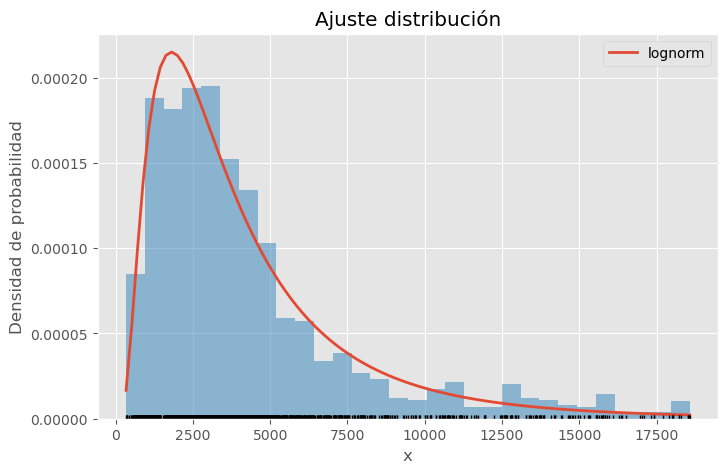

In [65]:
fig, ax = plt.subplots(figsize=(8,5))

plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados['distribucion'][0],
    ax=ax
);

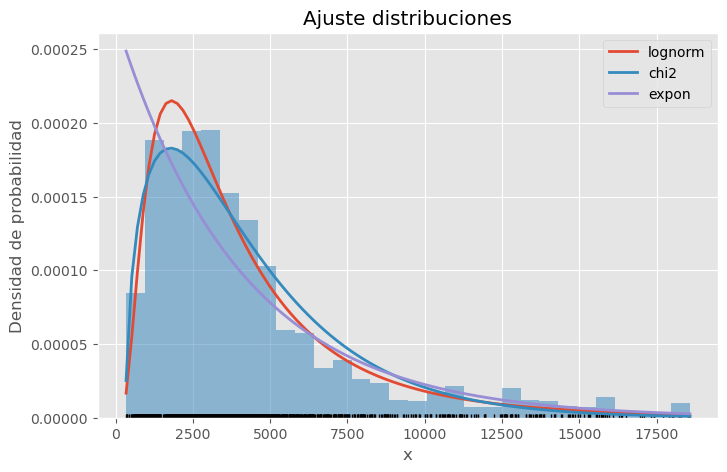

In [66]:
fig, ax = plt.subplots(figsize=(8,5))

plot_multiple_distribuciones(
    x=datos.to_numpy(),
    nombre_distribuciones=resultados['distribucion'][:3],
    ax=ax
);

In [67]:
# Definición de la distribución
distribucion = stats.lognorm

# Ajuste para obtener el valor de los parámetros
parametros   = distribucion.fit(datos.to_numpy())

# Muestreo aleatorio
distribucion.rvs(*parametros, size=2) 

array([15543.81263392,  4892.61867489])

In [4]:
from scipy.stats import kstest

In [69]:
datos = sns.load_dataset('diamonds')
datos = datos.loc[datos.cut == 'Fair', 'price']

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kstest

class AnalisisDistribuciones:
    """
    Clase para analizar y ajustar distribuciones estadísticas continuas a datos.

    Atributos:
    ----------
    data : array_like
        Datos para ajustar las distribuciones.
    distributions : list
        Lista de nombres de distribuciones disponibles en `scipy.stats`.
    results : dict or None
        Resultados de ajuste y prueba KS para cada distribución.

    Métodos:
    --------
    ajustar_distribuciones():
        Ajusta y evalúa cada distribución continua en la lista a los datos.
    obtener_mejores_distribuciones(criterio='ks_p_value', n=3):
        Retorna las mejores distribuciones basadas en un criterio específico.
    plot_histograma_y_distribucion():
        Grafica el histograma de los datos y la distribución ajustada.
    imprimir_resultados():
        Imprime los resultados del KS test para todas las distribuciones.
    """

    def __init__(self, data):
        """
        Inicializa un objeto AnalisisDistribuciones.

        Parámetros:
        -----------
        data : array_like
            Los datos a analizar y ajustar.
        """
        self.__data = np.asarray(data)  # Convertir a numpy array si no lo es
        self.__distributions = ['norm', 'expon', 'uniform', 'lognorm', 'weibull_min',
                                'gamma', 'beta', 'chi2', 't']
        self.__results = None  # Variable para almacenar los resultados de ajuste

    @property
    def data(self):
        """
        Obtiene los datos actuales.

        Returns:
        --------
        array_like
            Los datos almacenados en el objeto.
        """
        return self.__data

    @data.setter
    def data(self, new_data):
        """
        Establece nuevos datos y ajusta distribuciones.

        Parámetros:
        -----------
        new_data : array_like
            Nuevos datos a asignar.
        """
        self.__data = np.asarray(new_data)
        self.__results = None  # Reiniciar resultados al cambiar los datos
        self.ajustar_distribuciones()  # Ajustar automáticamente las distribuciones

    @property
    def distributions(self):
        """
        Obtiene la lista de distribuciones disponibles.

        Returns:
        --------
        list
            Lista de nombres de distribuciones.
        """
        return self.__distributions

    @distributions.setter
    def distributions(self, new_distributions):
        """
        Establece una nueva lista de distribuciones.

        Parámetros:
        -----------
        new_distributions : list
            Nueva lista de nombres de distribuciones.
        """
        self.__distributions = new_distributions
        self.__results = None  # Reiniciar resultados al cambiar las distribuciones

    @property
    def results(self):
        """
        Obtiene los resultados de ajuste y prueba KS.

        Returns:
        --------
        dict or None
            Resultados de ajuste y prueba KS para cada distribución, o None si no se han calculado.
        """
        return self.__results

    def ajustar_distribuciones(self):
        """
        Ajusta y evalúa cada distribución continua en la lista a los datos.

        Retorna:
        --------
        dict
            Un diccionario con los resultados de ajuste y prueba KS para cada distribución continua.
        """
        results = {}

        for distribution in self.__distributions:
            dist = getattr(stats, distribution)
            params = dist.fit(self.__data)
            ks_stat, ks_p_value = kstest(self.__data, distribution, args=params)

            results[distribution] = {
                'ks_stat': ks_stat,
                'ks_p_value': ks_p_value
            }

        self.__results = results  # Almacenar resultados en el atributo de la clase
        return results

    def obtener_mejores_distribuciones(self, criterio='ks_p_value', n=3):
        """
        Retorna las mejores distribuciones basadas en un criterio específico.

        Parámetros:
        -----------
        criterio : str, opcional
            El criterio para seleccionar las mejores distribuciones. Puede ser 'ks_p_value'.
            Por defecto es 'ks_p_value'.
        n : int, opcional
            Número de mejores distribuciones a retornar. Por defecto es 3.

        Retorna:
        --------
        list
            Lista de nombres de las mejores distribuciones.
        """
        if self.__results is None:
            self.ajustar_distribuciones()  # Ajustar distribuciones si aún no se han ajustado

        # Ordenar distribuciones por el criterio especificado
        sorted_distributions = sorted(self.__results.keys(), key=lambda x: self.__results[x][criterio], reverse=True)

        return sorted_distributions[:n]

    def plot_histograma_y_distribucion(self):
        """
        Grafica el histograma de los datos y la distribución mejor ajustada.
        """
        if self.__results is None:
            self.ajustar_distribuciones()  # Ajustar distribuciones si aún no se han ajustado

        best_distributions = self.obtener_mejores_distribuciones()

        plt.hist(self.__data, bins=30, density=True, alpha=0.6, color='g', label='Datos')

        for distribution in best_distributions:
            dist = getattr(stats, distribution)
            xmin, xmax = np.min(self.__data), np.max(self.__data)
            x = np.linspace(xmin, xmax, 100)
            p = dist.pdf(x, *dist.fit(self.__data))
            plt.plot(x, p, linewidth=2, label=f'{distribution} ajustada')

        plt.legend()
        plt.title('Histograma de datos y mejores distribuciones ajustadas')
        plt.xlabel('Datos')
        plt.ylabel('Densidad de probabilidad')
        plt.show()

    def imprimir_resultados(self):
        """
        Imprime los resultados del KS test para todas las distribuciones.
        """
        if self.__results is None:
            self.ajustar_distribuciones()  # Ajustar distribuciones si aún no se han ajustado

        for distribution, result in self.__results.items():
            print(f"Distribución: {distribution}")
            print(f"  KS estadístico: {result['ks_stat']}")
            print(f"  KS valor p: {result['ks_p_value']}")
            print()



C:\Users\Ashley\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


Distribución: norm
  KS estadístico: 0.16692744536016302
  KS valor p: 1.111506990349673e-39

Distribución: expon
  KS estadístico: 0.10883597681271057
  KS valor p: 4.603240165410763e-17

Distribución: uniform
  KS estadístico: 0.488205399098209
  KS valor p: 0.0

Distribución: lognorm
  KS estadístico: 0.027434988792896298
  KS valor p: 0.17386130955932377

Distribución: weibull_min
  KS estadístico: 0.06337762213032727
  KS valor p: 4.5847084017769e-06

Distribución: gamma
  KS estadístico: 0.10763352538153936
  KS valor p: 1.0697455564700814e-16

Distribución: beta
  KS estadístico: 0.12101423519016863
  KS valor p: 5.2760099278194815e-21

Distribución: chi2
  KS estadístico: 0.05286116457477241
  KS valor p: 0.0002377885215068998

Distribución: t
  KS estadístico: 0.1302127283524324
  KS valor p: 2.920324001677451e-24



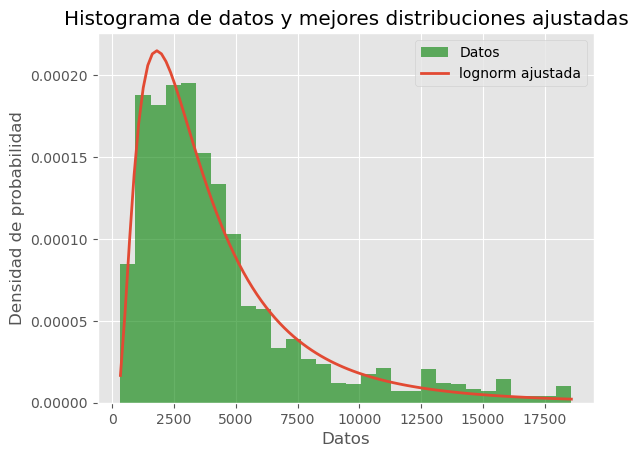

In [71]:

datos = sns.load_dataset('diamonds')
datos = datos.loc[datos.cut == 'Fair', 'price']
analisis = AnalisisDistribuciones(datos)

analisis.ajustar_distribuciones()
analisis.imprimir_resultados()

# Graficar histograma y distribuciones ajustadas
analisis.plot_histograma_y_distribucion()


In [6]:

# Semilla para reproducibilidad
np.random.seed(42)

# Generar datos sintéticos para diferentes distribuciones
n =  1500 # Tamaño de la muestra

# Distribución normal
datos_normal = np.random.normal(loc=0, scale=1, size=n)

# Distribución exponencial
datos_exponencial = np.random.exponential(scale=1, size=n)

# Distribución uniforme
datos_uniforme = np.random.uniform(low=-1, high=1, size=n)

# Distribución lognormal
datos_lognormal = np.random.lognormal(mean=0, sigma=1, size=n)

# Distribución Weibull
datos_weibull = np.random.weibull(a=1, size=n)

# Distribución gamma
datos_gamma = np.random.gamma(shape=2, scale=1, size=n)

# Distribución beta
datos_beta = np.random.beta(a=2, b=2, size=n)

# Distribución chi cuadrado
datos_chi2 = np.random.chisquare(df=2, size=n)

# Distribución t de Student
datos_t = np.random.standard_t(df=2, size=n)

# Distribución de Bernoulli (datos binarios)
datos_bernoulli = np.random.binomial(n=1, p=0.5, size=n)

# Distribución binomial
datos_binomial = np.random.binomial(n=10, p=0.5, size=n)

# Distribución de Poisson
datos_poisson = np.random.poisson(lam=3, size=n)

# Crear un DataFrame con los datos sintéticos
df = pd.DataFrame({
    'Normal': datos_normal,
    'Exponencial': datos_exponencial,
    'Uniforme': datos_uniforme,
    'Lognormal': datos_lognormal,
    'Weibull': datos_weibull,
    'Gamma': datos_gamma,
    'Beta': datos_beta,
    'Chi2': datos_chi2,
    'T-Student': datos_t,
    'Bernoulli': datos_bernoulli,
    'Binomial': datos_binomial,
    'Poisson': datos_poisson
})

# Mostrar las primeras filas del DataFrame
print(df.head())

     Normal  Exponencial  Uniforme  Lognormal   Weibull     Gamma      Beta  \
0  0.496714     0.314465 -0.542249   1.153786  0.173633  4.388432  0.282124   
1 -0.138264     1.743252  0.193704   2.338739  3.442712  1.429216  0.170210   
2  0.647689     0.689665  0.856364   1.999421  2.462159  1.500789  0.540310   
3  1.523030     0.080189  0.858279   1.790637  0.182662  0.476870  0.372014   
4 -0.234153     0.060335 -0.316189   0.449356  0.129147  6.246450  0.744448   

       Chi2  T-Student  Bernoulli  Binomial  Poisson  
0  4.144688  -0.469283          0         5        2  
1  7.633407   3.976689          1         4        5  
2  1.435201   2.234200          0         6        3  
3  3.552885   1.551740          0         6        4  
4  1.114723   2.009265          0         5        6  


In [16]:
# Acceder a la columna
datos_gamma = df['Gamma']


C:\Users\Ashley\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:6111: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


Distribución: norm
  KS estadístico: 0.014452138536213077
  KS valor p: 0.9081202783317368

Distribución: expon
  KS estadístico: 0.36052693085122656
  KS valor p: 4.0361872114010643e-175

Distribución: uniform
  KS estadístico: 0.25510079686119913
  KS valor p: 1.5169820702375275e-86

Distribución: lognorm
  KS estadístico: 0.01337096864038606
  KS valor p: 0.9480471669157257

Distribución: weibull_min
  KS estadístico: 0.02587842692851272
  KS valor p: 0.2630336338711001

Distribución: gamma
  KS estadístico: 0.013389113861389301
  KS valor p: 0.9474820951647462

Distribución: beta
  KS estadístico: 0.013436696124907166
  KS valor p: 0.9459830081297026

Distribución: chi2
  KS estadístico: 0.7113966051556531
  KS valor p: 0.0

Distribución: t
  KS estadístico: 0.01445191714233729
  KS valor p: 0.9081297203404861



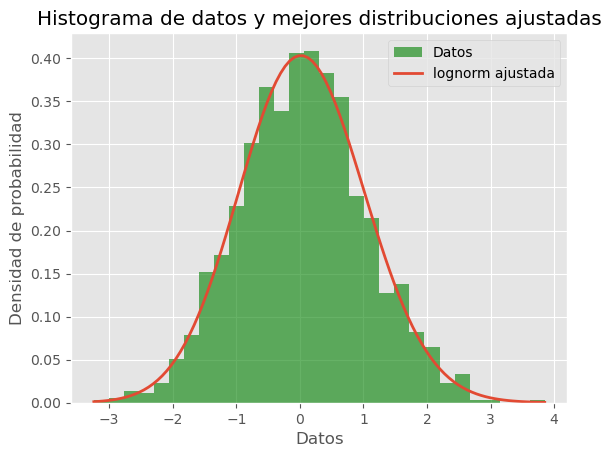

In [10]:
analisis = AnalisisDistribuciones(datos_norm)

analisis.ajustar_distribuciones()
analisis.imprimir_resultados()

# Graficar histograma y distribuciones ajustadas
analisis.plot_histograma_y_distribucion()

In [92]:
diamonds = sns.load_dataset("diamonds")
datos = diamonds['price'].values #

In [97]:
print(datos)

[ 326  326  327 ... 2757 2757 2757]


In [48]:
datos.to_numpy()

array([ 337., 2757., 2759., ..., 2743., 2745., 2747.])

In [83]:
print(datos_gamma)

0       4.388432
1       1.429216
2       1.500789
3       0.476870
4       6.246450
          ...   
1495    1.840190
1496    0.636512
1497    2.456059
1498    0.267424
1499    2.984536
Name: Gamma, Length: 1500, dtype: float64


In [50]:
print(datos)

8         337.0
91       2757.0
97       2759.0
123      2762.0
124      2762.0
          ...  
53757    2724.0
53800    2732.0
53863    2743.0
53879    2745.0
53882    2747.0
Name: price, Length: 1610, dtype: float64


In [36]:
from scipy.stats import mode
# Convertir datos a float para permitir NaN
datos = datos_gamma.astype(float)

# Generar índices aleatorios dentro del rango válido de datos
indices_a_eliminar = np.random.choice(len(datos), size=17, replace=False)

# Crear una copia de los datos para simular valores faltantes
datos_con_nulos = datos.copy()

# Asignar NaN a los índices seleccionados
datos_con_nulos[indices_a_eliminar] = np.nan

print("Cantidad de NaN después de simulación de valores faltantes:")
print(np.isnan(datos_con_nulos).sum())

# Imputar valores faltantes con diferentes estrategias (media, máximo, mínimo)
datos_imputados_media = np.where(np.isnan(datos_con_nulos), np.nanmean(datos_con_nulos), datos_con_nulos)
datos_imputados_max = np.where(np.isnan(datos_con_nulos), np.nanmax(datos_con_nulos), datos_con_nulos)
datos_imputados_min = np.where(np.isnan(datos_con_nulos), np.nanmin(datos_con_nulos), datos_con_nulos)





# Función para analizar distribuciones usando KS test
def analizar_distribuciones(datos):
    """
    Realiza un análisis de distribuciones usando el test Kolmogorov-Smirnov (KS).

    Esta función ajusta varias distribuciones estadísticas a los datos proporcionados
    utilizando el método de máxima verosimilitud y luego evalúa cada distribución ajustada
    utilizando el test KS para determinar la bondad del ajuste.

    Parameters
    ----------
    datos : array_like
        Datos para los cuales se ajustarán y evaluarán las distribuciones.

    Returns
    -------
    dict
        Un diccionario que contiene los resultados del ajuste y prueba KS para cada distribución.
        Las claves son los nombres de las distribuciones y los valores son diccionarios con las
        siguientes claves:
        - 'params': Parámetros ajustados de la distribución.
        - 'ks_stat': Estadístico KS calculado.
        - 'ks_p_value': Valor p del test KS.

    Notes
    -----
    Esta función utiliza las distribuciones 'norm', 'expon', 'uniform', 'lognorm', 'weibull_min',
    'gamma', 'beta', 'chi2' y 't' disponibles en `scipy.stats`.
    """
    distributions = ['norm', 'expon', 'uniform', 'lognorm', 'weibull_min', 'gamma', 'beta', 'chi2', 't']
    results = {}
    
    for distribution in distributions:
        dist = getattr(stats, distribution)
        params = dist.fit(datos)
        ks_stat, ks_p_value = kstest(datos, distribution, args=params)
        
        results[distribution] = {
            'params': params,
            'ks_stat': ks_stat,
            'ks_p_value': ks_p_value
        }
        
    return results

# Obtener resultados antes y después de la imputación para cada estrategia
resultados_original = analizar_distribuciones(datos)
resultados_imputados_media = analizar_distribuciones(datos_imputados_media)
resultados_imputados_max = analizar_distribuciones(datos_imputados_max)
resultados_imputados_min = analizar_distribuciones(datos_imputados_min)

# Mostrar resultados
print("\nResultados antes de la imputación:")
for dist, result in resultados_original.items():
    print(f"Distribución: {dist}")
    print(f"  KS estadístico: {result['ks_stat']}")
    print(f"  KS valor p: {result['ks_p_value']}\n")

print("\nResultados después de la imputación con la media:")
for dist, result in resultados_imputados_media.items():
    print(f"Distribución: {dist}")
    print(f"  KS estadístico: {result['ks_stat']}")
    print(f"  KS valor p: {result['ks_p_value']}\n")

print("\nResultados después de la imputación con el máximo:")
for dist, result in resultados_imputados_max.items():
    print(f"Distribución: {dist}")
    print(f"  KS estadístico: {result['ks_stat']}")
    print(f"  KS valor p: {result['ks_p_value']}\n")

print("\nResultados después de la imputación con el mínimo:")
for dist, result in resultados_imputados_min.items():
    print(f"Distribución: {dist}")
    print(f"  KS estadístico: {result['ks_stat']}")
    print(f"  KS valor p: {result['ks_p_value']}\n")


Cantidad de NaN después de simulación de valores faltantes:
17


C:\Users\Ashley\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\Ashley\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)



Resultados antes de la imputación:
Distribución: norm
  KS estadístico: 0.1052493403850625
  KS valor p: 6.371952542632301e-15

Distribución: expon
  KS estadístico: 0.1445470614420823
  KS valor p: 8.182909658317543e-28

Distribución: uniform
  KS estadístico: 0.5662404888893706
  KS valor p: 0.0

Distribución: lognorm
  KS estadístico: 0.02231777008694058
  KS valor p: 0.4374599123321734

Distribución: weibull_min
  KS estadístico: 0.029629475471887545
  KS valor p: 0.14074608382624987

Distribución: gamma
  KS estadístico: 0.01362738484045345
  KS valor p: 0.9397244194068397

Distribución: beta
  KS estadístico: 0.06063031167823124
  KS valor p: 3.096011726383763e-05

Distribución: chi2
  KS estadístico: 0.1684546880014664
  KS valor p: 1.1187852911417515e-37

Distribución: t
  KS estadístico: 0.08938098582592863
  KS valor p: 7.069590202942381e-11


Resultados después de la imputación con la media:
Distribución: norm
  KS estadístico: 0.1092601879923134
  KS valor p: 4.74815731493

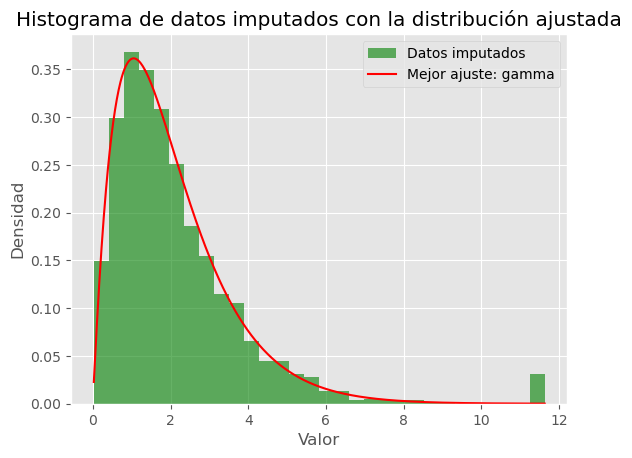

In [40]:
resultados_imputados_finales = resultados_imputados_media
datos_imputados_finales = datos_imputados_media
# Encontrar la distribución con el valor p más alto (mejor ajuste)
mejor_distribucion = max(resultados_imputados_finales, key=lambda k: resultados_imputados_finales[k]['ks_p_value'])
params_mejor_distribucion = resultados_imputados_finales[mejor_distribucion]['params']
# Graficar los datos y la mejor distribución
plt.hist(datos_imputados_max, bins=30, density=True, alpha=0.6, color='g', label='Datos imputados')

# Crear una serie de puntos en el rango de los datos para la curva de la distribución
x = np.linspace(min(datos_imputados_finales), max(datos_imputados_finales), 1000)
dist = getattr(stats, mejor_distribucion)
pdf_fitted = dist.pdf(x, *params_mejor_distribucion)

plt.plot(x, pdf_fitted, 'r-', label=f'Mejor ajuste: {mejor_distribucion}')
plt.legend(loc='upper right')
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Histograma de datos imputados con la distribución ajustada')
plt.show() 